In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Segmentation Project 

## Load Packages <a class="anchor" id="first-bullet"></a>

In [ ]:
!pip install imagehash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import multiprocessing
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

import cv2

#for image dupli
from PIL import Image
import imagehash


import re

## Extract data from tar

In [ ]:
!tar --gunzip --extract --verbose --file=drive/MyDrive/image_segmentation/images.tar.gz

Streaming output truncated to the last 5000 lines.
images/american_bulldog_194.jpg
images/Birman_175.jpg
images/american_bulldog_178.jpg
images/staffordshire_bull_terrier_93.jpg
images/Egyptian_Mau_58.jpg
images/havanese_44.jpg
images/english_cocker_spaniel_97.jpg
images/Ragdoll_111.jpg
images/american_pit_bull_terrier_159.jpg
images/english_setter_134.jpg
images/english_setter_87.jpg
images/wheaten_terrier_198.jpg
images/pug_180.jpg
images/boxer_172.jpg
images/Sphynx_197.jpg
images/german_shorthaired_2.jpg
images/British_Shorthair_9.jpg
images/pug_89.jpg
images/japanese_chin_39.jpg
images/Ragdoll_20.jpg
images/american_bulldog_111.jpg
images/yorkshire_terrier_112.jpg
images/Persian_88.jpg
images/pug_9.jpg
images/Birman_40.jpg
images/British_Shorthair_272.jpg
images/havanese_7.jpg
images/pomeranian_154.jpg
images/beagle_49.jpg
images/British_Shorthair_94.jpg
images/Persian_90.jpg
images/staffordshire_bull_terrier_30.jpg
images/samoyed_113.jpg
images/english_cocker_spaniel_46.jpg
images

In [ ]:
!tar --gunzip --extract --verbose --file=drive/MyDrive/image_segmentation/annotations.tar.gz

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

## Data Preparation (NEW)

In [ ]:
# Class: 1-37 Species: 1:Cat || 2:Dog   Breed: 1-25:Cat || 1-12:Dog
# correct index

df = pd.read_csv('annotations/list.txt', comment='#',header=None, sep=" ")
df.columns = ['image_name','class_index','specie_index','breed_index']
df = df.sort_values(by = 'image_name', ascending=True)
df = df.reset_index(drop=True)
print(df)

                image_name  class_index  specie_index  breed_index
0             Abyssinian_1            1             1            1
1            Abyssinian_10            1             1            1
2           Abyssinian_100            1             1            1
3           Abyssinian_101            1             1            1
4           Abyssinian_102            1             1            1
...                    ...          ...           ...          ...
7344  yorkshire_terrier_95           37             2           25
7345  yorkshire_terrier_96           37             2           25
7346  yorkshire_terrier_97           37             2           25
7347  yorkshire_terrier_98           37             2           25
7348  yorkshire_terrier_99           37             2           25

[7349 rows x 4 columns]


In [ ]:
# Get dict ("image_name": specie_index)
specie_dict = df.set_index("image_name")["specie_index"].to_dict()
print(specie_dict)

{'Abyssinian_1': 1, 'Abyssinian_10': 1, 'Abyssinian_100': 1, 'Abyssinian_101': 1, 'Abyssinian_102': 1, 'Abyssinian_103': 1, 'Abyssinian_104': 1, 'Abyssinian_105': 1, 'Abyssinian_106': 1, 'Abyssinian_107': 1, 'Abyssinian_108': 1, 'Abyssinian_109': 1, 'Abyssinian_11': 1, 'Abyssinian_110': 1, 'Abyssinian_111': 1, 'Abyssinian_112': 1, 'Abyssinian_113': 1, 'Abyssinian_114': 1, 'Abyssinian_115': 1, 'Abyssinian_116': 1, 'Abyssinian_117': 1, 'Abyssinian_118': 1, 'Abyssinian_119': 1, 'Abyssinian_12': 1, 'Abyssinian_120': 1, 'Abyssinian_121': 1, 'Abyssinian_122': 1, 'Abyssinian_123': 1, 'Abyssinian_124': 1, 'Abyssinian_125': 1, 'Abyssinian_126': 1, 'Abyssinian_127': 1, 'Abyssinian_128': 1, 'Abyssinian_129': 1, 'Abyssinian_13': 1, 'Abyssinian_130': 1, 'Abyssinian_131': 1, 'Abyssinian_132': 1, 'Abyssinian_133': 1, 'Abyssinian_134': 1, 'Abyssinian_135': 1, 'Abyssinian_136': 1, 'Abyssinian_137': 1, 'Abyssinian_138': 1, 'Abyssinian_139': 1, 'Abyssinian_14': 1, 'Abyssinian_140': 1, 'Abyssinian_141': 1

### Class for Data Cleaning

In [ ]:
class Clean_Data:
    def __init__(
                 self,
                 img_id_input,
                 mask_id_input,     
                 img_path_input,
                 mask_path_input,
                 specie_dict_input,
                ):
        
        print("\nRunning: Clean_Data")
        print("------------------------------------\n")

        self.specie_dict = specie_dict_input
        self.img_ids = img_id_input
        self.mask_ids = mask_id_input
        self.img_paths = img_path_input
        self.mask_paths = mask_path_input

        # TEST
        ## CHECK LENGTH
    
        if all(len(self.img_ids) != len(list_) for list_ in [self.mask_ids,self.img_paths,self.mask_paths] ):
            raise AssertionError("Lists of Id and path do not have the same length")
        else:
            print("Length Check Passed!\n")

        self.count_remove = 0
        self.run_clean()

        print("\nStop: Clean_Data")
        print("------------------------------------\n")

    def run_clean(self):
        # remove in the list those without labels
        
        print("Removing Unlabeled Data")
        self.remove_unlabeled_data()
        print(f"Number of data removed: {self.count_remove}")

        print("Removing Duplicate Data")
        self.remove_duplicate_data()
        print(f"Number of data removed: {self.count_remove}")


    def remove_unlabeled_data(self):

        # name without filetype .jpeg
        name_list = [img_id.split('.')[0] for img_id in self.img_ids]

        # list of img_name without label
        no_label_list = [img_name for img_name in name_list if img_name not in self.specie_dict]

        self.count_remove += len(no_label_list)

        # with path
        self.img_ids = [id for index,id in enumerate(self.img_ids) if name_list[index] not in no_label_list]
        self.mask_ids = [id for index,id in enumerate(self.mask_ids) if name_list[index] not in no_label_list]
        self.img_paths  = [path for index,path in enumerate(self.img_paths) if name_list[index] not in no_label_list]
        self.mask_paths = [path for index,path in enumerate(self.mask_paths) if name_list[index] not in no_label_list]

        #return updated_img_path, updated_mask_path


    def remove_duplicate_data(self):
        img_hashes = {}
        duplicate_list = []

        # get a list of duplicate images
        for img_path in self.img_paths:
            hash = imagehash.average_hash(Image.open(img_path))

            if hash in img_hashes:
                duplicate_list.append(img_path)   
            else:
                img_hashes[hash] = img_path

        self.count_remove += len(duplicate_list)

        temp_img_paths = self.img_paths
        temp_mask_paths = self.mask_paths
        temp_img_ids = self.img_ids
        temp_mask_ids = self.mask_ids

        self.img_paths, fix_img_list = zip(*[(path,index) for index,path in enumerate(temp_img_paths) if temp_mask_paths[index] not in duplicate_list])
        self.mask_paths, fix_mask_list = zip(*[(path,index) for index,path in enumerate(temp_mask_paths) if temp_mask_paths[index] not in duplicate_list])

        self.img_ids = [id for index,id in enumerate(temp_img_ids) if index in fix_img_list]
        self.mask_ids = [id for index,id in enumerate(temp_mask_ids) if index in fix_mask_list]

        #return updated_img_path, updated_mask_path
        

### Class for Loading and Preprocessing Images and Masks in Dataset

In [ ]:
class Load_Dataset:
    """NOTES:
        1. replace img_dir and mask_dir with list directly so i can create train and validation dataset (DONE)
        2. change img_path and mask_path because img_dir and mask_dir already cleaned before adding complete path (DONE)
        3. try to replace self.img_ids to os.listdir(img_dir) for direct cleaning to list (DONE)
        4. replace list into dictionary {"img_dir": ["dog_pic.jpg", ...]} (DONE)
        5. IMG and MASK are not the same again (DONE)
    """
    def __init__(self, img_dir, mask_dir, specie_dict,  classes, classes_limit, augmentation, preprocessing, fix_mask):

        print("\nRunning: Load_Dataset")
        print("------------------------------------\n")

        self.specie_dict = specie_dict
        self.classes = classes

        if isinstance(img_dir, str) and isinstance(mask_dir, str):
            self.img_dir = img_dir
            self.mask_dir = mask_dir
            self.img_ids = [img_ for img_ in os.listdir(img_dir) if not img_.startswith(".") and (img_.endswith(".jpg") or img_.endswith(".png"))]
            self.mask_ids = [mask_ for mask_ in os.listdir(mask_dir) if not mask_.startswith(".") and (mask_.endswith(".jpg") or mask_.endswith(".png"))]

        elif isinstance(img_dir, dict) and isinstance(mask_dir, dict):
            self.img_dir, self.img_ids = list(img_dir.items())[0]
            self.mask_dir, self.mask_ids = list(mask_dir.items())[0]

        else:
            raise TypeError("Possible cause of error: \n1. img_dir and mask_dir are both not str or dict \n2. img_dir and mask_dir are neither str nor dict")

        self.img_ids = sorted(self.img_ids)
        self.mask_ids = sorted(self.mask_ids)

        if self.img_ids[500].split(".")[0] != self.mask_ids[500].split(".")[0]:
            print(f"img: {self.img_ids[500]}")
            print(f"mask: {self.img_ids[500]}")

            print("BEFORE")
            print(f"img: {self.img_ids[499]}")
            print(f"mask: {self.img_ids[499]}")
            print("AFTER")
            print(f"img: {self.img_ids[501]}")
            print(f"mask: {self.img_ids[501]}")

            raise AssertionError("img and mask are not the same")
        else:
            print("SORTED IDs PASSED!")


        self.img_path = [os.path.join(self.img_dir,img_id) for img_id in self.img_ids]
        self.mask_path = [os.path.join(self.mask_dir,mask_id) for mask_id in self.mask_ids]
        
        self.img_path = sorted(self.img_path)
        self.mask_path = sorted(self.mask_path)

        print("Lengths before data cleaning")
        print(f"img_ids len: {len(self.img_ids)}")
        print(f"mask_ids len: {len(self.mask_ids)}")
        print(f"img_path len: {len(self.img_path)}")
        print(f"mask_path len: {len(self.mask_path)}")

        if all(len(self.img_ids) != len(list_) for list_ in [self.mask_ids,self.img_path,self.mask_path] ):
            raise AssertionError("Lists of Id and path do not have the same length")
        else:
            print("Length Check Passed!\n")

        if self.img_path[500].split("/")[-1].split(".")[0] != self.mask_path[500].split("/")[-1].split(".")[0]:
            print(f"img: {self.img_path[500]}")
            print(f"mask: {self.mask_path[500]}")

            print("BEFORE")
            print(f"img: {self.img_path[499]}")
            print(f"mask: {self.mask_path[499]}")
            print("AFTER")
            print(f"img: {self.img_path[501]}")
            print(f"mask: {self.mask_path[501]}")

            raise AssertionError("img and mask are not the same")
        else:
            print("PASSED PATH COMPARISON BEFORE CLEANING")

        #################################
        #Data clean
        data_clean = Clean_Data(img_id_input = self.img_ids,
                                mask_id_input = self.mask_ids,
                                img_path_input = self.img_path,
                                mask_path_input = self.mask_path,
                                specie_dict_input = self.specie_dict)

        self.img_path = data_clean.img_paths
        self.mask_path = data_clean.mask_paths
        self.img_ids = data_clean.img_ids
        self.mask_ids = data_clean.mask_ids

        print("Lengths after data cleaning")
        print(f"img_ids len: {len(self.img_ids)}")
        print(f"mask_ids len: {len(self.mask_ids)}")
        print(f"img_path len: {len(self.img_path)}")
        print(f"mask_path len: {len(self.mask_path)}")

        if all(len(self.img_ids) != len(list_) for list_ in [self.mask_ids,self.img_path,self.mask_path] ):
            raise AssertionError("Lists of Id and path do not have the same length")
        else:
            print("Length Check Passed!\n")
        #################################

        # Count class dict {"cat": 500, "dog": 1500}
        self.class_count = self.class_counter()
        print(self.class_count,"\n")

        # classes = 0: background || 1: cat || 2: dog   class_val = [0,1,2]
        if classes_limit:
            self.class_val = [self.classes.index(cls) for cls in classes_limit]
        else:
            self.class_val = [i for i,x in enumerate(self.classes)]

        self.fix_mask = fix_mask

        self.augmentation = augmentation
        self.preprocessing = preprocessing


        name_list = [class_.split("/")[-1].split(".")[0] for class_ in self.img_path]
        mask_list = [class_.split("/")[-1].split(".")[0] for class_ in self.mask_path]

        # TWO TESTS BECAUSE FIRST ONE IS PRODUCING FALSE PASS RESULT!
        if all(x != y for x,y in zip(name_list,mask_list)):
            raise AssertionError("FAILED: img_path and mask_path are incorrectly paired!")
        else:
            print("PASSED FIRST TEST: img_path and mask_path are correctly paired!")

        compare_ = self.img_path[500].split("/")[-1].split(".")[0]
        compare_list = [ self.mask_path[500].split("/")[-1].split(".")[0],   ]

        if self.img_path[500].split("/")[-1].split(".")[0] != self.mask_path[500].split("/")[-1].split(".")[0]:
            print(f"img: {self.img_path[500]}")
            print(f"mask: {self.mask_path[500]}")
            raise AssertionError("FAILED: img_path and mask_path are incorrectly paired!")
        else:
            print("PASSED SECOND TEST: img_path and mask_path are correctly paired!")


        print("\nStop: Load_Dataset")
        print("------------------------------------\n")
    
    def __getitem__(self,i):

        if self.img_path[i].split("/")[-1].split(".")[0] != self.mask_path[i].split("/")[-1].split(".")[0]:
            print(f"img: {self.img_path[i]}")
            print(f"mask: {self.mask_path[i]}")
            raise AssertionError("img and mask are not the same")

        # read img and mask
        img = cv2.imread(self.img_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path[i],0)

        if self.fix_mask:
            mask, specie_index = self.fix(i,mask)

        # separate classes into their own channels
        ## if mask values in list of classes (class_values) return true
        masks = [(mask == class_) for class_ in self.class_val]
        ## stack 2d masks (list) into a single 3d array (True = 1, False = 0)
        ## axis = -1 > add another axis || example shape (500,500, n_classes)
        mask = np.stack(masks, axis = -1).astype('float')

        # apply augmentations
        if self.augmentation:
            img, mask = self.augmentation(img=img, mask=mask)
 
        # apply preprocessing
        if self.preprocessing:
            img, mask = self.preprocessing(img=img, mask=mask)

        # fix values after preprocessing
        ## only works for the current problem (background, cat, dog)
        ## improve to work with multiple classes
        mask[mask > 0] = specie_index
        mask[mask <= 0] = 0

        return img, mask

    def fix(self,i,mask):
        find_name = self.img_ids[i].split('.')[0]
        #specie index 
        specie_index = self.specie_dict.get(find_name,None)
        if specie_index == None:
            print(f"{find_name} has no specie_index")


        #print("this is a test")
        #print(self.specie_dict.get("Egyptian_Mau_139",None))


        bg = 0
        condition_object = np.logical_or(mask == 1, mask ==3)
        condition_bg = (mask == 2)
        mask = np.where(condition_object,specie_index,np.where(condition_bg,bg,mask))

        return mask, specie_index
    
    def class_counter(self):

        # classes=["background","cat","dog"]
        name_list = [class_.split("/")[-1].split(".")[0] for class_ in self.img_path]
        specie_list = [self.specie_dict.get(name,None) for name in name_list] 
        class_count = {class_name: specie_list.count(class_id) for class_id,class_name in enumerate(self.classes) if class_name != "background"}


        return class_count



In [ ]:
def preprocess_fn(img,mask):

    # temporary
    preprocessed_img = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)
    preprocessed_mask = cv2.resize(mask, (224,224), interpolation=cv2.INTER_LINEAR)

    return preprocessed_img, preprocessed_mask


### Class for Loading Data from Dataset

In [ ]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class Dataloader(tf.keras.utils.Sequence):
    def __init__(self,
                 dataset,
                 dataset_size, # insert len of img_path from Load_Dataset class
                 batch_size,
                 shuffle=False):
        
        self.dataset = dataset
        self.dataset_size = dataset_size
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.indexes = np.arange(self.dataset_size)

        self.on_epoch_end()

    def __len__(self):
        # Number of Batches per Epoch
        return int(np.floor(self.dataset_size / self.batch_size))  # len(self.list_IDs)

    def __getitem__(self,i):
        start = i * self.batch_size
        stop = (i+1) * self.batch_size
        data = []

        for j in range(start,stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def on_epoch_end(self):
        #self.indexes = np.arange(self.dataset_size)

        if self.shuffle == True:
            np.random.shuffle(self.indexes)


### RUN

In [ ]:
"""NOTE:
    1. Consider splitting classes equally
    2. img_dir and img_name in pandas dataframe, try to make then equal in each element
"""

img_dir = "images"
mask_dir = "annotations/trimaps"

# remove hidden files and not jpg or png
img_inputs = [img_ for img_ in os.listdir(img_dir) if not img_.startswith(".") and (img_.endswith(".jpg") or img_.endswith(".png"))]
mask_inputs = [mask_ for mask_ in os.listdir(mask_dir) if not mask_.startswith(".") and (mask_.endswith(".jpg") or mask_.endswith(".png"))]
img_inputs = sorted(img_inputs)
mask_inputs = sorted(mask_inputs)

assert len(img_inputs) == len(mask_inputs), "img_inputs and mask_inputs do not have the same length"

# divide equally to prevent class imbalance in dataset
## this one may produce errors again 
cat_img = img_inputs[:2370]
dog_img = img_inputs[2370:]

cat_mask = mask_inputs[:2370]
dog_mask = mask_inputs[2370:]


train_img = cat_img[:len(cat_img)//2] + dog_img[:len(dog_img)//2]
train_mask = cat_mask[:len(cat_mask)//2] + dog_mask[:len(dog_mask)//2]

valid_img = cat_img[len(cat_img)//2:] + dog_img[len(dog_img)//2:]
valid_mask = cat_mask[len(cat_mask)//2:] + dog_mask[len(dog_mask)//2:]


########################################################################
###########################     TEST      ##############################
if train_img[500].split("/")[-1].split(".")[0] != train_mask[500].split("/")[-1].split(".")[0]:
    print(f"img: {train_img[500]}")
    print(f"mask: {train_mask[500]}")
    raise AssertionError("EQUALITY TEST: FAILED (TRAIN)")
else:
    print(f"img: {train_img[500]}")
    print(f"mask: {train_mask[500]}")
    print("EQUALITY TEST: PASSED (TRAIN)")

if valid_img[500].split("/")[-1].split(".")[0] != valid_mask[500].split("/")[-1].split(".")[0]:
    print(f"img: {valid_img[500]}")
    print(f"mask: {valid_mask[500]}")
    raise AssertionError("EQUALITY TEST: FAILED (VALIDATION)")
else:
    print(f"img: {valid_img[500]}")
    print(f"mask: {valid_mask[500]}")
    print("EQUALITY TEST: PASSED (VALIDATION)")
########################################################################


train_img_dict = {img_dir : train_img}
train_mask_dict = {mask_dir : train_mask}

valid_img_dict = {img_dir : valid_img}
valid_mask_dict = {mask_dir : valid_mask}


train_dataset = Load_Dataset(img_dir = train_img_dict,  # either str of directory or list of directory
                       mask_dir = train_mask_dict, # either str of directory or list of directory
                       specie_dict = specie_dict,  
                       classes=["background","cat","dog"], 
                       classes_limit=False, 
                       augmentation=False, # insert augmentation function here
                       preprocessing=preprocess_fn,# insert preprocessing function here
                       fix_mask=True)

valid_dataset = Load_Dataset(img_dir = valid_img_dict,  # either str of directory or list of directory
                       mask_dir = valid_mask_dict, # either str of directory or list of directory
                       specie_dict = specie_dict,  
                       classes=["background","cat","dog"], 
                       classes_limit=False, 
                       augmentation=False, # insert augmentation function here
                       preprocessing=preprocess_fn,# insert preprocessing function here
                       fix_mask=True)


In [ ]:
# Batch Gradient Descent: Batch Size = Size of Training Set
# Stochastic Gradient Descent: Batch Size = 1
# Mini-Batch Gradient Descent: 1 < Batch Size < Size of Training Set

loaded_train_dataset = Dataloader(dataset = train_dataset,
                            dataset_size = len(train_dataset.img_path),
                            batch_size = 29,
                            shuffle = True
                            )

loaded_valid_dataset = Dataloader(dataset = valid_dataset,
                            dataset_size = len(valid_dataset.img_path),
                            batch_size = 29,
                            shuffle = False
                            )


In [ ]:
#batch image shape (batch_size, shape, channels)
print(loaded_train_dataset[0][0].shape)
#batch mask shape (batch_size, shape, num_classes)
print(loaded_train_dataset[0][1].shape)

img,mask = loaded_train_dataset.dataset[5]
print(img.shape)

print(len(loaded_train_dataset))
print(len(train_dataset.img_path))

(29, 224, 224, 3)
(29, 224, 224, 3)
(224, 224, 3)
126
3662


[0. 2.]
(224, 224)
3626


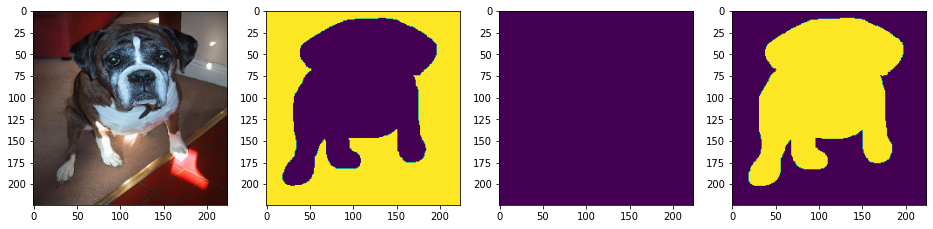

In [ ]:
img, mask = train_dataset[2000]
print(np.unique(mask))
print(mask[...,0].shape)
print(valid_dataset.img_ids.index("yorkshire_terrier_44"+".jpg"))
#print(dataset.img_ids.index("Egyptian_Mau_129"+".jpg"))
#print("Egyptian_Mau_129"+".jpg")
fig, arr = plt.subplots(1,4, figsize=(16,5))
arr[0].imshow(img)
arr[1].imshow(mask[...,0])
arr[2].imshow(mask[...,1])
arr[3].imshow(mask[...,2])

### Class Distribution <a class="anchor" id="2-9"></a> 

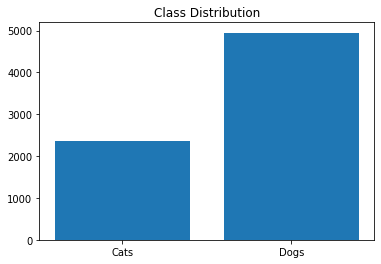

In [ ]:
image_list_temp = [x.split('/')[1].split('.')[0] for x in image_list]
specie_list = df[df['image_name'].isin(image_list_temp)]['specie_index'].tolist()

cat_count = specie_list.count(1)
dog_count = specie_list.count(2)

class_list = ['Cats','Dogs']
values = [cat_count,dog_count]

plt.bar(class_list,values)
plt.title('Class Distribution')
plt.show()

### Preprocess and load pairs of image and mask into dataset <a class="anchor" id="2-10"></a> 

In [ ]:
# Specie index 1:Cat || 2:Dog
# Separate lists
dog_image_list = [image_name 
                  for image_name in image_list 
                  if df.loc[df['image_name'] == image_name.split('/')[1].split('.')[0]
                            , 'specie_index'].iloc[0] == 2
                 ]

cat_image_list = [image_name 
                  for image_name in image_list 
                  if df.loc[df['image_name'] == image_name.split('/')[1].split('.')[0]
                            , 'specie_index'].iloc[0] == 1
                 ]

dog_mask_list = [mask_name 
                  for mask_name in mask_list 
                  if df.loc[df['image_name'] == mask_name.split('/')[-1].split('.')[0]
                            , 'specie_index'].iloc[0] == 2
                 ]

cat_mask_list = [mask_name 
                  for mask_name in mask_list 
                  if df.loc[df['image_name'] == mask_name.split('/')[-1].split('.')[0]
                            , 'specie_index'].iloc[0] == 1
                 ]

In [ ]:
import albumentations as A

def aug_fn(image,mask,specie_index):
    
    transform = A.Compose([
        A.HorizontalFlip(p=1),
        A.VerticalFlip(p=1),
        A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, per_channel=True, p=1),
        #A.JpegCompression(quality_lower=0, quality_upper=1, p=1),
        A.RandomBrightnessContrast(p=0.2),
    ])
    
    # augment image and mask
    data = {"image": image, "mask": mask}
    aug_data = transform(**data)
    aug_img = aug_data["image"]
    aug_mask = aug_data["mask"]
    
    #convert numpy array back to tf tensor
    aug_img = tf.cast(aug_img,tf.float32)
    aug_mask = tf.cast(aug_mask,tf.int8)
    
    return aug_img, aug_mask

def preprocess(image_input, mask_input, specie_index, augment_=False, shape=(224,224)):
        
    # load image and mask
    img = tf.io.read_file(image_input)
    img = tf.image.decode_jpeg(img, channels=3)      
    mask = tf.io.read_file(mask_input)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.cast(mask,dtype=tf.int8)
        
    # if augment_ is true, use albumentation
    if augment_:
        img,mask = tf.numpy_function(func=aug_fn, inp=[img,mask,specie_index], Tout=(tf.float32,tf.int8))
        shape1, shape2 = shape
        img.set_shape((shape1,shape2,3))
        mask.set_shape((shape1,shape2,1))
        
    #continue preprocessing
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, shape, method='nearest')
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, shape, method='nearest')

    # replace mask values for classification purposes
    specie_index = tf.constant(specie_index,dtype='int8')
    bg = tf.constant(0,dtype='int8')
    condition_object = tf.math.equal(mask,1) | tf.math.equal(mask,3)
    condition_bg = tf.math.equal(mask,2)
    mask = tf.where(condition_object,specie_index,mask)
    mask = tf.where(condition_bg,bg,mask)

    return img, mask

In [ ]:
# Specie index 1:Cat || 2:Dog

# # CAT DATASET

cat_dataset = tf.data.Dataset.from_tensor_slices((cat_image_list,cat_mask_list))
specie_index = 1
cat_dataset = cat_dataset.map(lambda image_input,mask_input: preprocess(image_input,mask_input,specie_index))

# DOG DATASET

dog_dataset = tf.data.Dataset.from_tensor_slices((dog_image_list,dog_mask_list))
specie_index = 2
dog_dataset = dog_dataset.map(lambda image_input,mask_input: preprocess(image_input,mask_input,specie_index))

# AUGMENTED CAT DATASET

aug_cat_dataset = tf.data.Dataset.from_tensor_slices((cat_image_list,cat_mask_list))
specie_index = 1
augment_ = True
aug_cat_dataset = aug_cat_dataset.map(lambda image_input,mask_input: preprocess(image_input,mask_input,specie_index,augment_))


In [ ]:
# COMBINE CAT AND DOG DATASET INTO SINGLE DATASET
train_dataset = dog_dataset.concatenate(cat_dataset).concatenate(aug_cat_dataset)

In [ ]:
# COUNT NUMBER OF EXAMPLES IN EACH DATASET
print("cat dataset: ",cat_dataset.cardinality().numpy())
print("augmented cat dataset: ",aug_cat_dataset.cardinality().numpy())
print("dog dataset: ",dog_dataset.cardinality().numpy())
print("combined dataset: ",train_dataset.cardinality().numpy())

cat dataset:  2358
augmented cat dataset:  2358
dog dataset:  4950
combined dataset:  9666


In [ ]:
# PREPARE DATASET FOR TRAINING
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.int8, name=None))


(351, 500, 3)


Text(0.5, 1.0, 'dog')

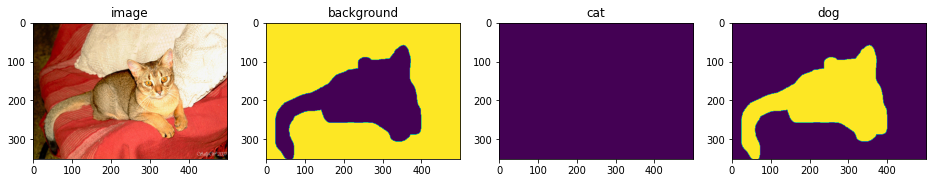

In [ ]:
img, mask = dataset[5]
print(mask.shape)
fig,arr = plt.subplots(1,4, figsize=(16,5))
arr[0].imshow(img)
arr[0].set_title("image")
# background
arr[1].imshow(mask[...,0].squeeze())
arr[1].set_title("background")
# cat
arr[2].imshow(mask[...,1].squeeze())
arr[2].set_title("cat")
# dog
arr[3].imshow(mask[...,2].squeeze())
arr[3].set_title("dog")

## Data Preparation

### Load lists of images and masks <a class="anchor" id="2-1"></a> 

In [ ]:
image_list = ["images/"+f for f in os.listdir("images") if not f.startswith(".") and (f.endswith(".jpg") or f.endswith(".png"))]
mask_list = ["annotations/trimaps/"+f for f in os.listdir("annotations/trimaps") if not f.startswith(".") and (f.endswith(".jpg") or f.endswith(".png"))]

print(f"number of images: {len(image_list) }")
print(f"number of masks: {len(mask_list) }")

number of images: 7390
number of masks: 7390


### Visualize image and mask <a class="anchor" id="2-2"></a> 

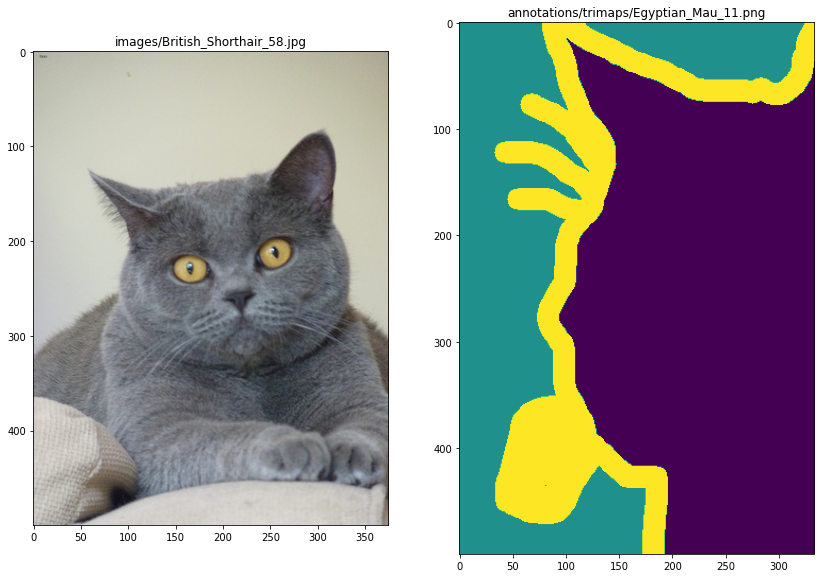

In [ ]:
img = mpimg.imread(image_list[0])
mask = mpimg.imread(mask_list[0])

fig, arr = plt.subplots(1,2, figsize = (14,10))
arr[0].imshow(img)
arr[0].set_title("{}".format(image_list[0]))
arr[1].imshow(mask)
arr[1].set_title("{}".format(mask_list[0]))
plt.show()


### Sort lists of images and masks <a class="anchor" id="2-3"></a> 

we can see at the image and mask shown above that the indices of the pair do not match 

In [ ]:
image_list.sort()
mask_list.sort()

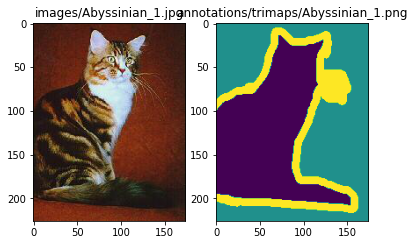

In [ ]:
img = mpimg.imread(image_list[1200])
mask = mpimg.imread(mask_list[1200])


fig, arr = plt.subplots(1,2)
arr[0].imshow(img)
arr[0].set_title("{}".format(image_list[0]))
arr[1].imshow(mask)
arr[1].set_title("{}".format(mask_list[0]))
plt.show()

### Load image labels into pandas dataframe <a class="anchor" id="2-5"></a> 

In [ ]:
import pandas as pd

# Class: 1-37 Species: 1:Cat || 2:Dog   Breed: 1-25:Cat || 1-12:Dog
# correct index

df = pd.read_csv('annotations/list.txt', comment='#',header=None, sep=" ")
df.columns = ['image_name','class_index','specie_index','breed_index']
df = df.sort_values(by = 'image_name', ascending=True)
df = df.reset_index(drop=True)
print(df)

                image_name  class_index  specie_index  breed_index
0             Abyssinian_1            1             1            1
1            Abyssinian_10            1             1            1
2           Abyssinian_100            1             1            1
3           Abyssinian_101            1             1            1
4           Abyssinian_102            1             1            1
...                    ...          ...           ...          ...
7344  yorkshire_terrier_95           37             2           25
7345  yorkshire_terrier_96           37             2           25
7346  yorkshire_terrier_97           37             2           25
7347  yorkshire_terrier_98           37             2           25
7348  yorkshire_terrier_99           37             2           25

[7349 rows x 4 columns]


### Check if all pair of images and masks have labels <a class="anchor" id="2-6"></a> 

In [ ]:
def label_check(img_input, df):
    
    image_name = img_input.split('/')[1].split('.')[0]

    if df.loc[df['image_name'] == image_name, 'specie_index'].empty:
        print(f"error image: {image_name} (has no label)")
        
        no_label = img_input
        return no_label

In [ ]:
no_label_list = map(lambda img_input: label_check(img_input,df), image_list)
no_label_list = list(filter(None,no_label_list))
print(f"\nnumber of images without labels: {len(no_label_list)} out of {len(image_list)} ({41/7390 * 100:.2f}% are not labeled)")

Since only 0.55% of our dataset do not have labels, it might be for the best to simple ignore them and only use labeled data. We can try to deal with the unlabeled data in the future to compare if it will improve the model's performance

We can just label the 41 images that does not contain label but in reality we may have to deal with thousands of images that have this issue and doing it manually is not efficient and may not be worth it

### Remove unlabeled pairs <a class="anchor" id="2-7"></a> 

In [ ]:
# list of indices of images from image_list that exist in no_label_list 
temp_index_list = [i for i, x in enumerate(image_list) if x in no_label_list]
print(temp_index_list)

[136, 181, 612, 692, 694, 696, 705, 708, 710, 712, 716, 717, 718, 729, 766, 784, 792, 799, 1033, 1042, 1049, 1070, 1079, 1086, 1095, 1107, 1141, 1170, 2095, 3381, 3670, 3671, 3672, 3688, 4955, 5459, 5460, 5461, 5462, 6899, 6905]


In [ ]:
# remove images and masks that does not have classification labels
image_list = [x for i, x in enumerate(image_list) if i not in temp_index_list]
mask_list = [x for i, x in enumerate(mask_list) if i not in temp_index_list]

In [ ]:
# check new number of images and masks after removing unlabeled images
print(f"number of images: {len(image_list)} and number of masks: {len(mask_list)}")

number of images: 7349 and number of masks: 7349


### Check duplicates in images <a class="anchor" id="2-8"></a> 

(explain here why we need to remove duplicates) (may prevent overfitting some images)

In [ ]:
!pip install imagehash

In [ ]:
# check for duplicates
from PIL import Image
import imagehash

# image_fns : List of training image files

img_hashes = {}
duplicate_list = []
count = 0
test_list = image_list[:100]

for img_fn in image_list:
    #print(img_fn)
    hash = imagehash.average_hash(Image.open(img_fn))

    if hash in img_hashes:
        print( '{} duplicate of {}'.format(img_fn, img_hashes[hash]) )
        
        duplicate_list.append(img_fn)
        
        load1 = mpimg.imread(img_fn)
        load2 =mpimg.imread(img_hashes[hash])
        fig, arr = plt.subplots(1,2)
        arr[0].imshow(load1)
        arr[1].imshow(load2)
        plt.show()
        count += 1
        
    else:
        img_hashes[hash] = img_fn
        


5 images were wrongly chosen as duplicates out of 41

we can remove all of these duplicates including the wrongly predicted as duplicates for now and compare the performance later on if we are to use duplicates (try to convert to grayscale next time)

In [ ]:
# temporary index list of duplicates
temp_index_list = [i for i, x in enumerate(image_list) if x in duplicate_list]

# remove duplicates
image_list = [x for i, x in enumerate(image_list) if i not in temp_index_list]
mask_list = [x for i, x in enumerate(mask_list) if i not in temp_index_list]

In [ ]:
# check new number of images and masks after removing duplicate images
print(f"number of images: {len(image_list)} and number of masks: {len(mask_list)}")

number of images: 7308 and number of masks: 7308


### Class Distribution <a class="anchor" id="2-9"></a> 

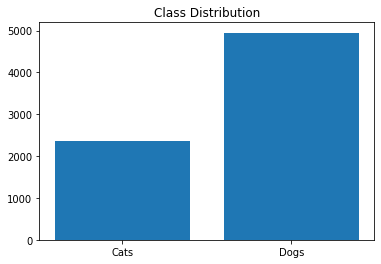

In [ ]:
image_list_temp = [x.split('/')[1].split('.')[0] for x in image_list]
specie_list = df[df['image_name'].isin(image_list_temp)]['specie_index'].tolist()

cat_count = specie_list.count(1)
dog_count = specie_list.count(2)

class_list = ['Cats','Dogs']
values = [cat_count,dog_count]

plt.bar(class_list,values)
plt.title('Class Distribution')
plt.show()

(mention here how to can be problematic to train on imbalance dataset)

### Preprocess and load pairs of image and mask into dataset <a class="anchor" id="2-10"></a> 

In [ ]:
# Specie index 1:Cat || 2:Dog
# Separate lists
dog_image_list = [image_name 
                  for image_name in image_list 
                  if df.loc[df['image_name'] == image_name.split('/')[1].split('.')[0]
                            , 'specie_index'].iloc[0] == 2
                 ]

cat_image_list = [image_name 
                  for image_name in image_list 
                  if df.loc[df['image_name'] == image_name.split('/')[1].split('.')[0]
                            , 'specie_index'].iloc[0] == 1
                 ]

dog_mask_list = [mask_name 
                  for mask_name in mask_list 
                  if df.loc[df['image_name'] == mask_name.split('/')[-1].split('.')[0]
                            , 'specie_index'].iloc[0] == 2
                 ]

cat_mask_list = [mask_name 
                  for mask_name in mask_list 
                  if df.loc[df['image_name'] == mask_name.split('/')[-1].split('.')[0]
                            , 'specie_index'].iloc[0] == 1
                 ]

In [ ]:
import albumentations as A

def aug_fn(image,mask,specie_index):
    
    transform = A.Compose([
        A.HorizontalFlip(p=1),
        A.VerticalFlip(p=1),
        A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, per_channel=True, p=1),
        #A.JpegCompression(quality_lower=0, quality_upper=1, p=1),
        A.RandomBrightnessContrast(p=0.2),
    ])
    
    # augment image and mask
    data = {"image": image, "mask": mask}
    aug_data = transform(**data)
    aug_img = aug_data["image"]
    aug_mask = aug_data["mask"]
    
    #convert numpy array back to tf tensor
    aug_img = tf.cast(aug_img,tf.float32)
    aug_mask = tf.cast(aug_mask,tf.int8)
    
    return aug_img, aug_mask

def preprocess(image_input, mask_input, specie_index, augment_=False, shape=(224,224)):
        
    # load image and mask
    img = tf.io.read_file(image_input)
    img = tf.image.decode_jpeg(img, channels=3)      
    mask = tf.io.read_file(mask_input)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.cast(mask,dtype=tf.int8)
        
    # if augment_ is true, use albumentation
    if augment_:
        img,mask = tf.numpy_function(func=aug_fn, inp=[img,mask,specie_index], Tout=(tf.float32,tf.int8))
        shape1, shape2 = shape
        img.set_shape((shape1,shape2,3))
        mask.set_shape((shape1,shape2,1))
        
    #continue preprocessing
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, shape, method='nearest')
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, shape, method='nearest')

    # replace mask values for classification purposes
    specie_index = tf.constant(specie_index,dtype='int8')
    bg = tf.constant(0,dtype='int8')
    condition_object = tf.math.equal(mask,1) | tf.math.equal(mask,3)
    condition_bg = tf.math.equal(mask,2)
    mask = tf.where(condition_object,specie_index,mask)
    mask = tf.where(condition_bg,bg,mask)

    return img, mask

In [ ]:
# Specie index 1:Cat || 2:Dog

# # CAT DATASET

cat_dataset = tf.data.Dataset.from_tensor_slices((cat_image_list,cat_mask_list))
specie_index = 1
cat_dataset = cat_dataset.map(lambda image_input,mask_input: preprocess(image_input,mask_input,specie_index))

# DOG DATASET

dog_dataset = tf.data.Dataset.from_tensor_slices((dog_image_list,dog_mask_list))
specie_index = 2
dog_dataset = dog_dataset.map(lambda image_input,mask_input: preprocess(image_input,mask_input,specie_index))

# AUGMENTED CAT DATASET

aug_cat_dataset = tf.data.Dataset.from_tensor_slices((cat_image_list,cat_mask_list))
specie_index = 1
augment_ = True
aug_cat_dataset = aug_cat_dataset.map(lambda image_input,mask_input: preprocess(image_input,mask_input,specie_index,augment_))


In [ ]:
# COMBINE CAT AND DOG DATASET INTO SINGLE DATASET
train_dataset = dog_dataset.concatenate(cat_dataset).concatenate(aug_cat_dataset)

In [ ]:
# COUNT NUMBER OF EXAMPLES IN EACH DATASET
print("cat dataset: ",cat_dataset.cardinality().numpy())
print("augmented cat dataset: ",aug_cat_dataset.cardinality().numpy())
print("dog dataset: ",dog_dataset.cardinality().numpy())
print("combined dataset: ",train_dataset.cardinality().numpy())

cat dataset:  2358
augmented cat dataset:  2358
dog dataset:  4950
combined dataset:  9666


In [ ]:
# PREPARE DATASET FOR TRAINING
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.int8, name=None))


## Model(s) <a class="anchor" id="third-bullet"></a> 

### Vanilla U-Net

In [ ]:
import tensorflow.keras.layers as tfl

In [ ]:
def conv_block(inputs=None,
               n_filters=32,
               dropout_prob=0,
               max_pooling=True
              ):
    
    conv = tfl.Conv2D(filters=n_filters,
                 kernel_size=3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(inputs)
    conv = tfl.Conv2D(filters=n_filters,
                 kernel_size=3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = tfl.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tfl.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv
    
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, 
                     contractive_input, 
                     n_filters=32):
    
    up = tfl.Conv2DTranspose(filters = n_filters,
                         kernel_size = 3,
                         strides = 2,
                         padding = 'same')(expansive_input)
    
    merge = tfl.concatenate([up,contractive_input], axis = 3)
    
    conv = tfl.Conv2D(filters = n_filters, 
                  kernel_size = 3,    
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    
    conv = tfl.Conv2D(filters = n_filters, 
                  kernel_size = 3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    return conv
    

In [ ]:
def unet_model(input_size=(96,128,3), 
               n_filters=32,
               n_classes=3):
    
    inputs = tfl.Input(input_size)
    
    # Contracting Path (Encoding)
    cblock1 = conv_block(inputs,n_filters)
    cblock2 = conv_block(cblock1[0],2*n_filters)
    cblock3 = conv_block(cblock2[0],4*n_filters)
    cblock4 = conv_block(cblock3[0],8*n_filters, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=False)
    
    # Expanding Path (Decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    
    conv9 = tfl.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = tfl.Conv2D(filters = n_classes, kernel_size = 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs,outputs=conv10)
    
    return model
    

In [ ]:
unet = unet_model()

In [ ]:
unet.summary()

In [ ]:
unet.compile(optimizer='adam',
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(unet,show_shapes=True)

### U-Net with MobileNetV2 encoder

In [ ]:
import tensorflow as tf
# use pretrained model MobileNetV2 as Encoder
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
for i in layer_names:
  x= base_model.get_layer(i).output
  print(x)


In [ ]:
down_stack.summary()

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
from IPython.display import clear_output

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


In [ ]:
for images, masks in train_dataset.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          #validation_data=test_batches,
                          callbacks=[DisplayCallback()])


### U-Net with VGG16 encoder

Modified U-net using pretrained VGG16 model as the encoder
https://arxiv.org/pdf/1806.07554.pdf

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
width, height = 224, 224

base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False, input_shape=(width, height, 3))
 
layer_names = [
    'block1_conv2', # 224,224,64
    'block2_conv2', # 112,112,128
    'block3_conv3', # 56,56,256
    'block4_conv3', # 28,28,512
    'block5_conv3', # 14,14,512
    'block5_pool',  # 7,7,512
]

base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False

# change to mod_VGG_16
VGG_16 = tf.keras.models.Model(base_model.input,
                               base_model_outputs)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
VGG_16.summary()

In [ ]:
print(VGG_16.get_layer("input_1").output)
for i in layer_names:
  x= VGG_16.get_layer(i).output
  print(x)

In [ ]:
def VGG16_Unet_decoder(expansive_input, 
                     contractive_input, 
                     n_filters=32):

  # deconvolution
  # new shape = [(shape + 2(padding) - kernel_size)/stride]  + 1 (reverse this formula for deconvolution new shape)
  # doubles shape size
  up = tfl.Conv2DTranspose(filters = n_filters,
                         kernel_size = 3,
                         strides = 2,
                         padding = 'same')(expansive_input)

  # combine expansive and contractive conv
  merge = tfl.concatenate([up,contractive_input], axis = 3)

  # kernel_initializer="he_normal" helps to mitigate vanishing and exploding gradients problem
  conv = tfl.Conv2D(filters = n_filters, 
                  kernel_size = 3,    
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)

  conv = tfl.Conv2D(filters = n_filters, 
                  kernel_size = 3,    
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

  return conv

In [ ]:
def VGG16_Unet(n_classes):

  """
    VGG16 = contract1,contract2,contract3, contract4, contract5
    contract5 -> conv2d -> conv2d

    'block1_conv2', # 224,224,64
    'block2_conv2', # 112,112,128
    'block3_conv3', # 56,56,256
    'block4_conv3', # 28,28,512
    'block5_conv3', # 14,14,512
    'block5_pool',  # 7,7,512
  """
    
  inputs = tf.keras.layers.Input(shape=(width,height,3))

  contract_blocks = VGG_16(inputs)

  # last maxpool to connect to conv2d
  cb_last = contract_blocks[-1]

  # cb_last contains 512 filters, (7x7)
  # applying padding="same" results in p = 1
  # new shape = [(shape + 2(padding) - kernel_size)/stride]  + 1
  # new shape = 7
  conv_last1 = tfl.Conv2D(filters = 1024, 
                  kernel_size = 3,    
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(cb_last)

  conv_last2 = tfl.Conv2D(filters = 1024, 
                  kernel_size = 3,    
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv_last1)


  # expansive path (concatenate )

  ## fifth block
  conv_5 = VGG16_Unet_decoder(expansive_input = conv_last2, 
                     contractive_input = contract_blocks[4], 
                     n_filters= 512)

  ## fourth block
  conv_4 = VGG16_Unet_decoder(expansive_input = conv_5, 
                     contractive_input = contract_blocks[3], 
                     n_filters= 512)

  ## third block

  conv_3 = VGG16_Unet_decoder(expansive_input = conv_4, 
                     contractive_input = contract_blocks[2], 
                     n_filters= 256)

  ## second block
  conv_2 = VGG16_Unet_decoder(expansive_input = conv_3, 
                     contractive_input = contract_blocks[1], 
                     n_filters= 128)

  ## first block

  conv_1 = VGG16_Unet_decoder(expansive_input = conv_2, 
                     contractive_input = contract_blocks[0], 
                     n_filters= 64)


  conv_out = tfl.Conv2D(filters = 64,
                 kernel_size = 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv_1)
    


  conv_out = tfl.Conv2D(filters = n_classes, kernel_size = 1, padding='same')(conv_out)


  model = tf.keras.Model(inputs=inputs,outputs=conv_out)


  return model

In [ ]:
VGG16_Unet = VGG16_Unet(n_classes = 3)

In [ ]:
VGG16_Unet.summary()

In [ ]:
tf.keras.utils.plot_model(VGG16_Unet,show_shapes=True)

In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 4.8 MB/s eta 0:00:00


In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
VGG16_Unet.compile(optimizer='adam',
              loss=sm.losses.categorical_focal_dice_loss,
              metrics=[sm.metrics.f1_score, sm.metrics.f2_score, sm.metrics.iou_score])

In [ ]:
from IPython.display import clear_output

In [ ]:
# # for images, masks in loaded_dataset.take(2):
# #   sample_image, sample_mask = images[0], masks[0]
# #   display([sample_image, sample_mask])

# #batch image shape (batch_size, shape, channels)
# print(loaded_dataset[0][0].shape)
# #batch mask shape (batch_size, shape, num_classes)
# print(loaded_dataset[0][1].shape)

# print(len(loaded_dataset))

# # test 
# img_test, mask_test = dataset[5]
# #add axis to the beginning (1,m,n) shape = (m,n)
# img_inp = np.expand_dims(img_test, axis = 0)
# predict_mask = VGG16_Unet.predict(img_inp)

# display(dataset[5])
# display(dataset[5],predict=True)
#display()

In [ ]:
# CALLBACKS

def display():

    plt.figure(figsize=(15, 15))

    img = cv2.imread("./images/yorkshire_terrier_39.jpg")
    img = cv2.resize(img,(224,224))

    img_inp = np.expand_dims(img, axis = 0)
    mask = VGG16_Unet.predict(img_inp)

    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(mask[...,0].squeeze())
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(mask[...,1].squeeze())
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.imshow(mask[...,2].squeeze())
    plt.axis('off')



filepath = "drive/MyDrive/image_segmentation/{epoch:02d}-{sm.metrics.f1_score:0.2f}"

to_monitor = sm.metrics.f1_score, sm.metrics.f2_score, sm.metrics.iou_score

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    #display()

    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
# use fit instead of fit_generator
model_history = VGG16_Unet.fit(
    loaded_dataset,
    steps_per_epoch = len(loaded_dataset),
    epochs = 40,
    #callbacks = [DisplayCallback()],
)

#### TEST

In [ ]:
model = sm.Unet('vgg16', classes=3, activation='softmax')

In [ ]:
optim = tf.keras.optimizers.Adam(0.0001)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 2, 2])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optim,total_loss,metrics)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./drive/MyDrive/image_segmentation/test_best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

model_history = model.fit(
    loaded_dataset,
    steps_per_epoch = len(loaded_dataset),
    epochs = 40,
    callbacks = callbacks,
)

Epoch 1/40
253/253 [==============================] - ETA: 0s - loss: 0.6281 - iou_score: 0.3663 - f1-score: 0.4263

253/253 [==============================] - 175s 598ms/step - loss: 0.6281 - iou_score: 0.3663 - f1-score: 0.4263 - lr: 1.0000e-04
Epoch 2/40
 62/253 [======>.......................] - ETA: 1:55 - loss: 0.5751 - iou_score: 0.4354 - f1-score: 0.4767

KeyboardInterrupt: ignored

### U-Net with EfficientNetB7

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB7

# Train Model

**Caching**: When working with large datasets, it can be time-consuming to load and preprocess the data every time you want to use it. The cache() method allows you to store the preprocessed data in memory or on disk, so that it can be reused without the need to preprocess it again. This can improve the performance of your model and reduce the training time.

**Shuffling**: When training a model, it is often beneficial to shuffle the training data so that the model is not biased by the order of the examples. The shuffle() method shuffles the elements of the dataset randomly, so that the model is trained on a diverse set of examples.

**Batching**: When training a model, it is often more efficient to process the data in smaller batches rather than processing the entire dataset at once. The batch() method divides the dataset into smaller batches, which can be used to train the model in a more efficient and controlled way.

In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32



In [ ]:
model_history = unet.fit(train_dataset, epochs=EPOCHS)

Epoch 1/5
303/303 [==============================] - 118s 342ms/step - loss: 0.6451 - accuracy: 0.7079
Epoch 2/5
303/303 [==============================] - 44s 144ms/step - loss: 0.6682 - accuracy: 0.6732
Epoch 3/5
303/303 [==============================] - 43s 143ms/step - loss: 0.6659 - accuracy: 0.6611
Epoch 4/5
303/303 [==============================] - 43s 142ms/step - loss: 0.6592 - accuracy: 0.6592
Epoch 5/5
 79/303 [======>.......................] - ETA: 31s - loss: 0.7382 - accuracy: 0.6006

KeyboardInterrupt: ignored

In [ ]:
import pickle

In [ ]:
pickle.dump(model,open('MLmodel.pkl','wb'))

In [ ]:
pickled_model=pickle.load(open('MLmodel.pkl','rb'))

In [ ]:
plt.plot(model_history.history["accuracy"])

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = pickled_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(pickled_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 9s 9s/step


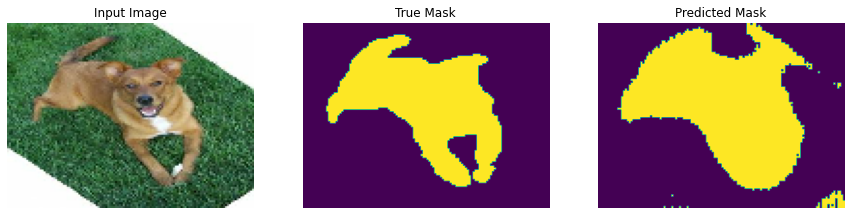

1/1 [==============================] - 0s 18ms/step


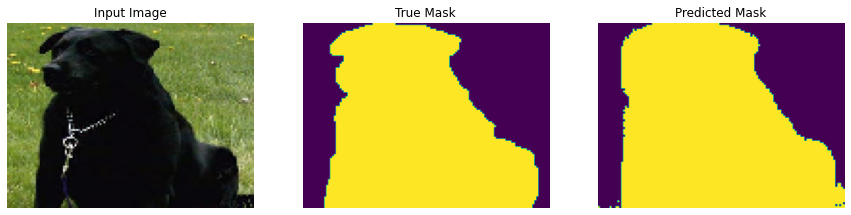

1/1 [==============================] - 0s 17ms/step


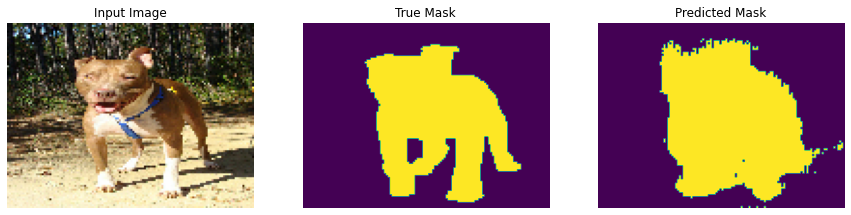

1/1 [==============================] - 0s 17ms/step


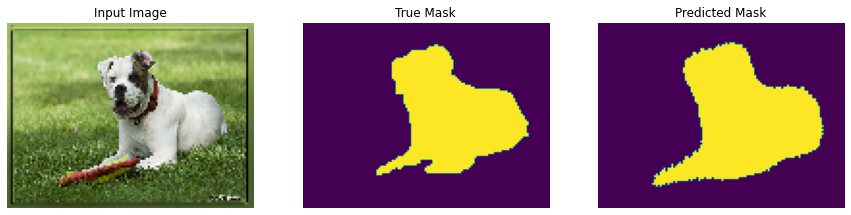

1/1 [==============================] - 0s 17ms/step


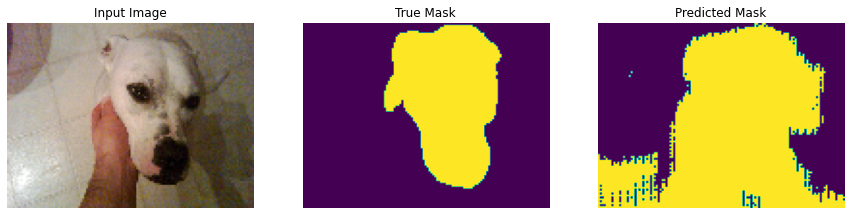

1/1 [==============================] - 0s 21ms/step


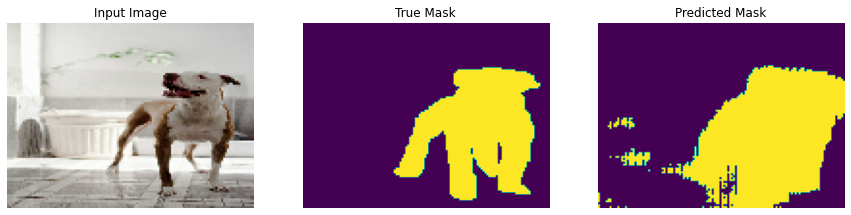

In [ ]:
show_predictions(train_dataset, 6)

In [ ]:
%matplotlib inline
import copy

In [ ]:
def show_predictions1(dataset, num=1):
    """
    Displays the first image of each of the num batches
    """
  
    for image, mask in dataset.take(num):
        
        print(f"before {image.shape}")
        
        pred_mask = pickled_model.predict(image)

        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = pred_mask[..., tf.newaxis]

        image1 = image[0].numpy()
        image2 = image[0].numpy()
        mask_dat = mask[0].numpy()
        pred_mask_one = pred_mask[0].numpy()

        #print(np.unique(pred_mask_one, return_counts=True))

        unique_, counts_ = np.unique(pred_mask_one,return_counts=True)
        uniq_dict = dict(zip(unique_, counts_))
        
        del uniq_dict[0]

        print(uniq_dict)
        pred_name = max(uniq_dict, key=uniq_dict.get)

        #print(unique_, counts_)
        
        pred_mask_one = pred_mask_one.astype(np.uint8)
        
        #print(f"mask dtype {mask.dtype } || pred_mask dtype {pred_mask_one.dtype}")
        
        ## TRUE MASK
        # Find the contours of the binary image
        contours, _ = cv2.findContours(mask_dat, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw the contours on the image
        new = cv2.drawContours(image1, contours, -1, (0, 255, 0), thickness = 2)
        
      

        ## PREDICTED MASK
        # Find the contours of the binary image        
        contours1, _ = cv2.findContours(pred_mask_one, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw the contours on the image
        new2 = cv2.drawContours(image2, contours1, -1, (0, 255, 0), thickness = 2)

        # VISUALIZE
        fig, arr = plt.subplots(2,2)
        arr[0][0].imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
        arr[0][0].set_title("TRUE mask")

        arr[0][1].imshow(new)
        arr[0][1].set_title("TRUE contour")

        arr[1][0].imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[0]))
        arr[1][0].set_title("PREDICT mask")

        arr[1][1].imshow(new2)
        arr[1][1].set_title("PREDICT contour")
        fig.suptitle("PREDICTION: {predict_out}".format(predict_out="dog" if pred_name == 1 else "cat"))

        plt.show()
                      

before (32, 128, 128, 3)
1/1 [==============================] - 1s 705ms/step


{1: 868, 2: 2711}


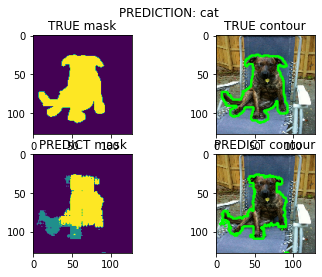

before (32, 128, 128, 3)
1/1 [==============================] - 0s 30ms/step


{1: 3794, 2: 152}


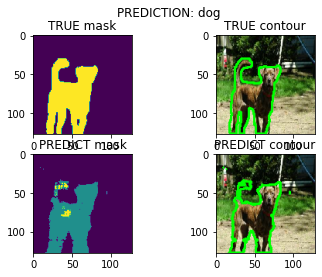

before (32, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step


{1: 1472, 2: 5290}


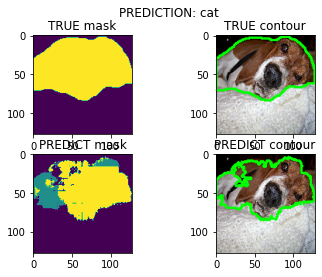

before (32, 128, 128, 3)
1/1 [==============================] - 0s 23ms/step


{1: 1685, 2: 8149}


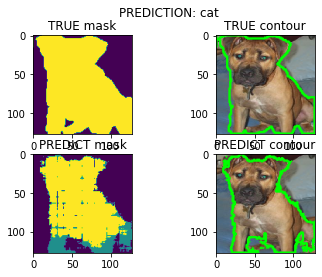

before (32, 128, 128, 3)
1/1 [==============================] - 0s 23ms/step


{1: 3905, 2: 2987}


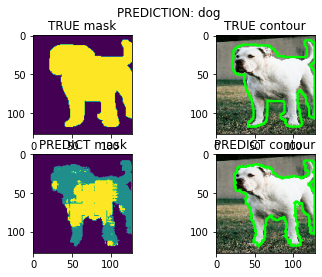

before (32, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step


{1: 680, 2: 5893}


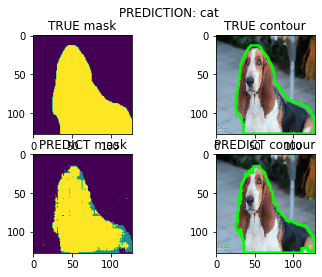

before (32, 128, 128, 3)
1/1 [==============================] - 0s 21ms/step


{1: 7593}


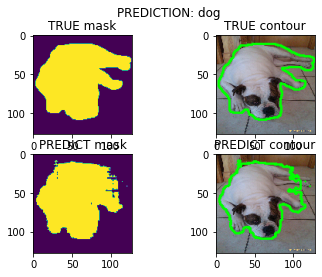

before (32, 128, 128, 3)
1/1 [==============================] - 0s 26ms/step


{1: 500, 2: 6712}


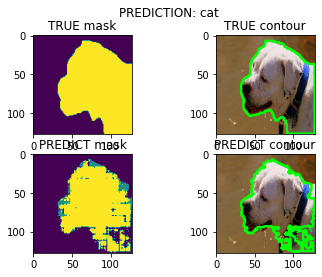

before (32, 128, 128, 3)
1/1 [==============================] - 0s 26ms/step


{1: 3090, 2: 320}


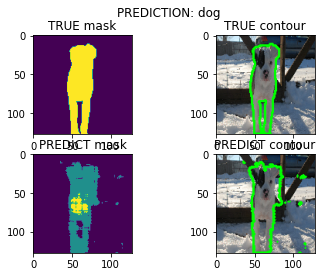

before (32, 128, 128, 3)
1/1 [==============================] - 0s 23ms/step


{1: 5713, 2: 1059}


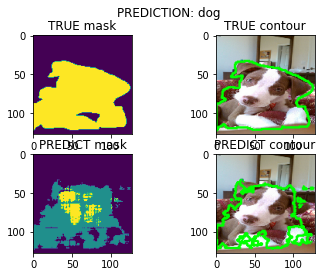

In [ ]:
import cv2
show_predictions1(train_dataset, num = 10)